<a href="https://colab.research.google.com/github/nahumsa/NLP/blob/main/Text%20Classification%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using a CNN
This notebook is completely based on the keras.io [code examples](https://keras.io/examples/nlp/text_classification_from_scratch/).

In [ ]:
import tensorflow as tf
import numpy as np

# 1) Data

## 1.1) Downloading the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  15.8M      0  0:00:05  0:00:05 --:--:-- 19.9M


Let's only classify the positive and negative reviews, thus we need to delete the `unsup` folder.

In [ ]:
!rm -r aclImdb/train/unsup

In order to generate the dataset that we will run and validate, we will use `tf.keras.preprocessing.text_dataset_from_directory`. We will split the train folder into a validation dataset and a training dataset.

## 1.2) Generating the keras dataset

In [ ]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", 
    batch_size=batch_size,
)

print(
    f"# of batches in raw_train_ds: {tf.data.experimental.cardinality(raw_train_ds)}"
    )
print(
    f"# of batches in raw_val_ds: {tf.data.experimental.cardinality(raw_val_ds)}"
    )
print(
    f"# of batches in raw_test_ds: {tf.data.experimental.cardinality(raw_test_ds)}"
    )

Let's see some data points:

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
0
b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situatio

## 1.3) Data Preprocessing

We see that there are some tags that  should not be on the text, for instance `<br />`. Let's clear the data from those tags by preprocessing our data.

In [ ]:
import string
import re

def apply_standardization(input_data):
    lower_case = tf.strings.lower(input_data)
    without_html = tf.strings.regex_replace(lower_case, "<br />", " ")
    return tf.strings.regex_replace(
        without_html, f"[{re.escape(string.punctuation)}]", ""
    )

Let's define our `TextVectorization` layer, which is an embedding layer that will represent our text as a vector in a space with `embedding_dim` dimension.

In this layer we will also define a maximum sequence lenght in order to fit our CNN model.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 20000
embedding_dim = 128
sequence_length = 500


vectorize_layer = TextVectorization(
    standardize=apply_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

Let's vectorize the data using asychronous CPU processing and buffering of the data in order to rain on GPUs. However, if we would export this model to production we need to accept raw strings as inputs, which will be done at the end of the training.

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, axis=-1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# 2) Building the CNN model

## 2.1) Constructing the model

In [ ]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(None,),
                        dtype="int64",
                        name="input")

x = layers.Embedding(max_features,
                     embedding_dim,
                     name="embedding")(inputs)

x = layers.Dropout(0.5,
                   name="droput_1")(x)

x = layers.Conv1D(128, 
                  7,
                  padding="valid",
                  activation="relu",
                  strides=3,
                  name="conv_1")(x)

x = layers.Conv1D(128, 
                  7,
                  padding="valid",
                  activation="relu",
                  strides=3,
                  name="conv_2")(x)

x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128,
                 activation="relu",
                 name="dense_1")(x)
x = layers.Dropout(0.5,
                   name="droput_2")(x)

outputs = layers.Dense(1,
                       activation="sigmoid",
                       name="output")(x)

model = tf.keras.Model(inputs, outputs,
                       name="CNN")

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
droput_1 (Dropout)           (None, None, 128)         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
conv_2 (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512   

## 2.2) Training the model

In [ ]:
epochs = 5

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                    )

Epoch 1/3
625/625 [==============================] - 120s 191ms/step - loss: 0.6073 - accuracy: 0.6087 - val_loss: 0.3163 - val_accuracy: 0.8664
Epoch 2/3
625/625 [==============================] - 114s 183ms/step - loss: 0.2665 - accuracy: 0.8940 - val_loss: 0.3087 - val_accuracy: 0.8784
Epoch 3/3
625/625 [==============================] - 114s 183ms/step - loss: 0.1399 - accuracy: 0.9494 - val_loss: 0.5124 - val_accuracy: 0.8432


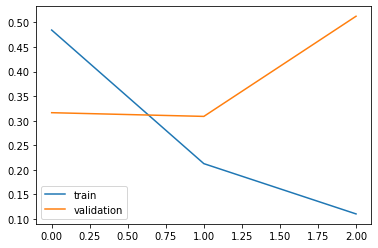

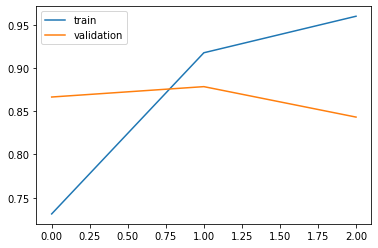

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train")
plt.plot(epochs, val_loss, label="validation")
plt.legend()
plt.show()

epochs = range(len(train_loss))
plt.plot(epochs, train_accuracy, label="train")
plt.plot(epochs, val_accuracy, label="validation")
plt.legend()
plt.show()

We see that the model overfits, we should fix that!

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

782/782 [==============================] - 26s 34ms/step - loss: 0.6127 - accuracy: 0.8155


# 3) Creating a model that can be deployed

In [ ]:
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Convert to vocab indices
indices = vectorize_layer(inputs)
# Convert to predictions of a CNN
outputs = model(indices)


deploy_model = tf.keras.Model(inputs, outputs)
deploy_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

deploy_loss, deploy_acc = deploy_model.evaluate(raw_test_ds)

782/782 [==============================] - 36s 45ms/step - loss: 0.6157 - accuracy: 0.8158


In [ ]:
# assert the loss and accuracy on the training model and the deploy
# model
assert deploy_acc == test_acc, "Deploy and test doesn't match"
assert deploy_loss == test_loss, "Deploy and test doesn't match"

# 4) Testing our model

In [ ]:
sad_text = "I'm is sad!"
great_text = "I'm Great!"
happy_text = "I'm happy!"
pred_sad = deploy_model.predict([str.encode(sad_text)])[0]
pred_great = deploy_model.predict([str.encode(great_text)])[0]
pred_happy = deploy_model.predict([str.encode(pred_happy)])[0]

In [ ]:
assert pred_sad < 0.5, "Sad prediction incorrect"
assert pred_great > 0.5, "Great prediction incorrect"
assert pred_happy > 0.5, "Happy prediction incorrect"

AssertionError: ignored

We can see that our model performs poorly when we are using this dataset and we want the model to predict simple things such as saying that "I'm sad" is negative.